In [105]:
import importlib_resources
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import *
from scipy.stats import *
from dtuimldmtools import *
import pandas as pd
from sklearn.feature_extraction.text import *
from nltk.stem import *
import scipy.linalg as linalg
import seaborn as sb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.linalg import svd 
import math
from sympy import *

### LOAD FILES

In [106]:
test_data = pd.read_csv("./test.csv")
training_data = pd.read_csv("./train.csv")

display(training_data.head())
display(test_data.head())


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [107]:
columns = training_data.columns
print(columns)
print(len(columns))

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
12


### Remove useless columns


In [108]:
refined_training_data = training_data.drop(['Name','Ticket','Cabin','PassengerId','Embarked'],axis=1)
refined_training_data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,male,22.0,1,0,7.2500
1,1,1,female,38.0,1,0,71.2833
2,1,3,female,26.0,0,0,7.9250
3,1,1,female,35.0,1,0,53.1000
4,0,3,male,35.0,0,0,8.0500
...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000
887,1,1,female,19.0,0,0,30.0000
888,0,3,female,NaN,1,2,23.4500
889,1,1,male,26.0,0,0,30.0000


### Check for NANS

In [109]:
refined_training_data.isnull().any()

Survived    False
Pclass      False
Sex         False
Age          True
SibSp       False
Parch       False
Fare        False
dtype: bool

### Replace NAN age with mean val

In [110]:
age_average = refined_training_data['Age'].mean()
refined_training_data['Age'] = refined_training_data['Age'].fillna(value=age_average)
refined_training_data.isnull().any()

Survived    False
Pclass      False
Sex         False
Age         False
SibSp       False
Parch       False
Fare        False
dtype: bool

### Binarize Sex column and int all columns


In [111]:
if type(refined_training_data['Sex'][0]) is str :
    refined_training_data['Sex'] = (refined_training_data['Sex']=='male').astype(int)
refined_training_data = (refined_training_data).astype(int)
refined_training_data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,1,22,1,0,7
1,1,1,0,38,1,0,71
2,1,3,0,26,0,0,7
3,1,1,0,35,1,0,53
4,0,3,1,35,0,0,8
...,...,...,...,...,...,...,...
886,0,2,1,27,0,0,13
887,1,1,0,19,0,0,30
888,0,3,0,29,1,2,23
889,1,1,1,26,0,0,30


### Reorder survived col to last for PCA later

In [112]:
columns = [  'Sex', 'Age', 'SibSp', 'Parch','Pclass', 'Fare','Survived',]
refined_data = refined_training_data[columns]
refined_data.head()

,Sex,Age,SibSp,Parch,Pclass,Fare,Survived
0,1,22,1,0,3,7,0
1,0,38,1,0,1,71,1
2,0,26,0,0,3,7,1
3,0,35,1,0,1,53,1
4,1,35,0,0,3,8,0


7


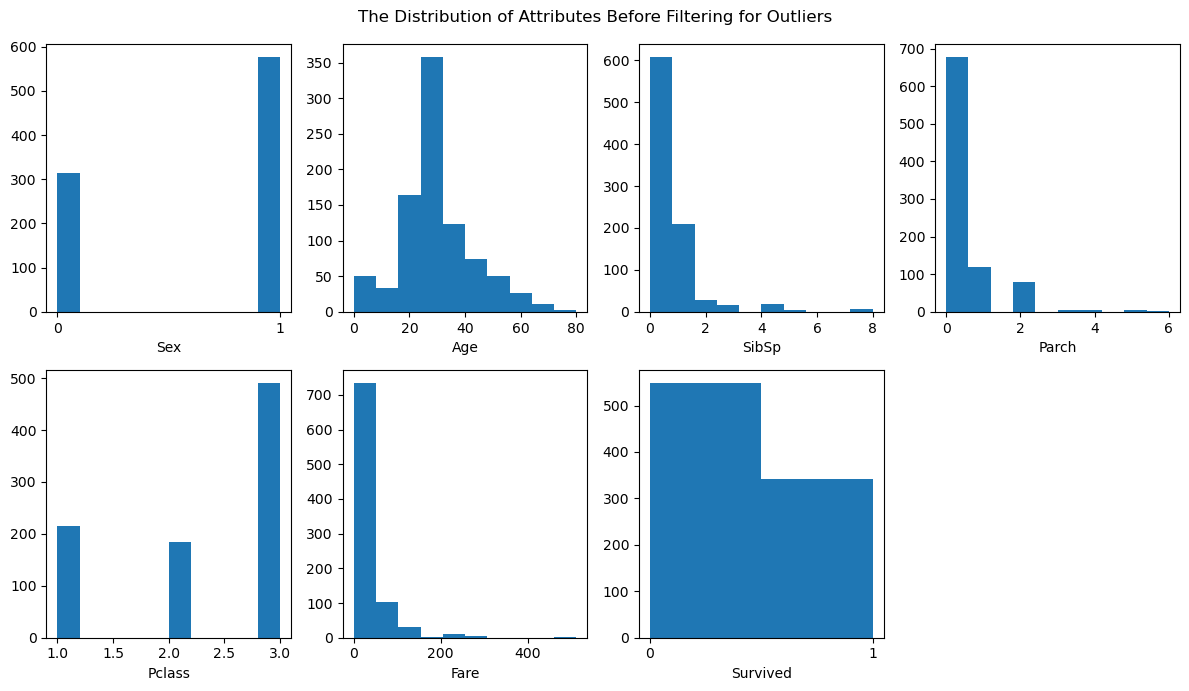

In [113]:
M = (len(refined_data.columns))
N = len(refined_data)
columns = refined_data.columns
plt.figure(figsize=(12, 7))
# units = ['mu U/ml','yrs','','','mm','kg/m^2','mmol/L','mm Hg','']
u = np.floor(np.sqrt(M))
v = np.ceil(float(M) / u)
limits = [600,600,600,300,300,300,400,400,400]
plt.suptitle('The Distribution of Attributes Before Filtering for Outliers')
print(M)
for i in range(M):

    plt.subplot(int(u), int(v), i + 1)
    plt.hist(refined_data[columns[i]],bins=(2 if columns[i]=='Survived' else 10))
    plt.xlabel(columns[i])
    if columns[i] in ['Survived','Sex']:
        plt.xticks([0,1])

    # plt.ylim(0,limits[i])

plt.tight_layout()
plt.show()


### Correlation Matrix Heatmap

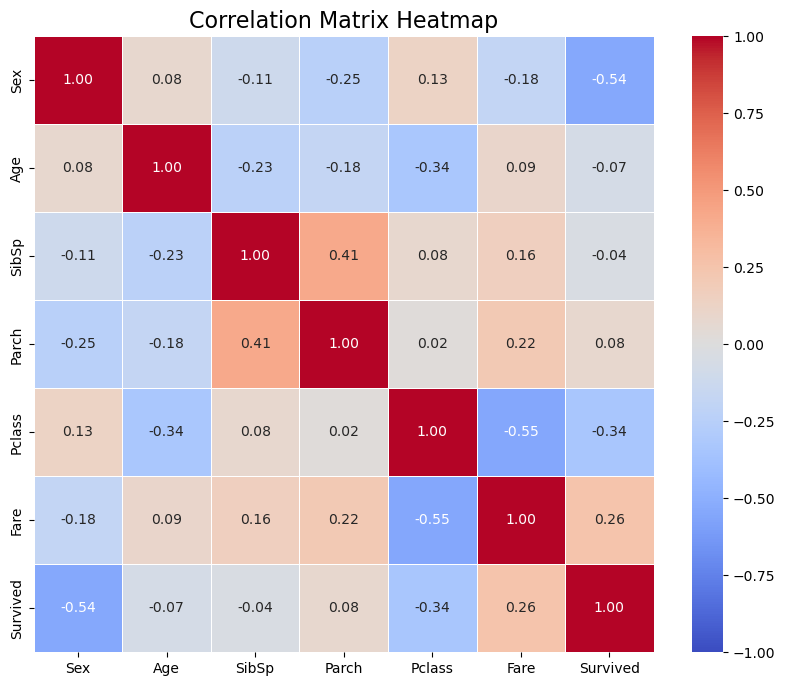

In [114]:
correlation_matrix = refined_data.corr()

plt.figure(figsize=(10, 8))

sb.heatmap(
    correlation_matrix, 
    annot=True,  
    fmt=".2f",   
    cmap="coolwarm",  
    vmin=-1, vmax=1, 
    linewidths=0.5,  
)


plt.title("Correlation Matrix Heatmap", fontsize=16)


plt.show()

### PCA test

In [115]:
X = refined_data.to_numpy()[:,:-1]
N = len(X[:,0])
print(N)
squigglyX = (X - np.ones((N, 1)) * X.mean(axis=0))/X.std(axis=0)
squigglyX = squigglyX
U, S, Vh = svd(squigglyX, full_matrices=False)
U = Matrix(U)
pcaHomemade = squigglyX @ Vh.T

# changing format back to panda dataframe
pca_dict = {}
for i in range(1, M): 
    pca_dict[f'PC{i}'] = pcaHomemade[:, i-1]


pca_df = pd.DataFrame(pca_dict)

display(pca_df)

891


,PC1,PC2,PC3,PC4,PC5,PC6
0,-0.947503,0.864038,0.560904,0.336615,0.372364,0.122156
1,1.532353,-1.307776,-0.728028,-0.005461,1.019088,-0.347528
2,-0.468859,0.490283,-1.599904,-0.085037,0.319528,0.407028
3,1.332692,-1.077518,-0.825225,0.038493,1.021172,-0.630780
4,-1.303902,-0.080274,0.297806,-0.291252,-0.120442,0.434617
...,...,...,...,...,...,...
886,-0.758559,-0.420178,0.298255,0.461180,-0.160124,-0.481888
887,0.754016,-0.647545,-1.462072,0.976182,0.301444,-1.108624
888,1.218799,1.543750,-0.828355,-1.265589,-0.757854,0.217766
889,-0.088896,-1.127043,0.412334,0.882918,-0.155255,-1.127031


### Projection onto PCAs

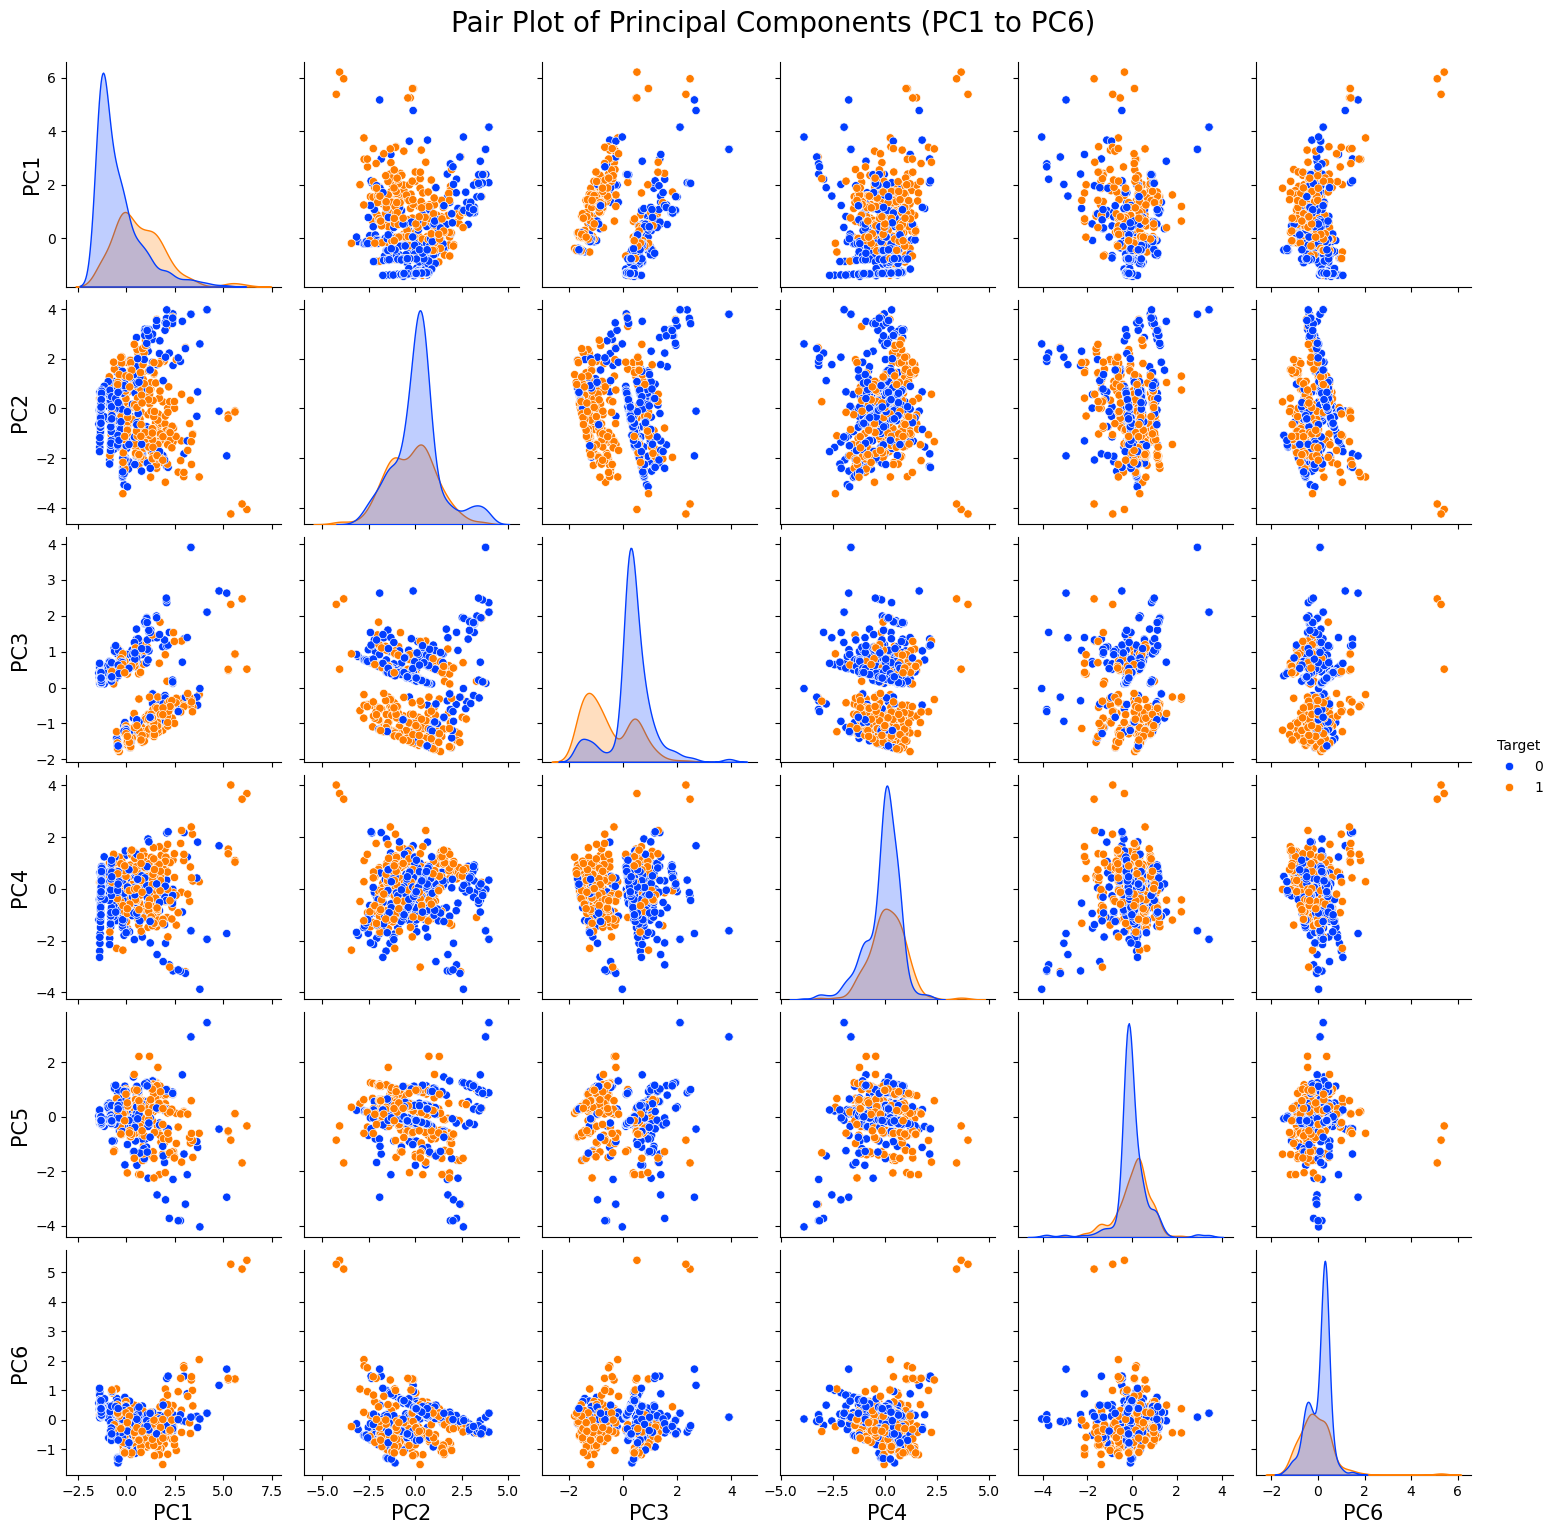

In [116]:
pca_df["Target"] = refined_data["Survived"]

pair_plot = sb.pairplot(
    pca_df,
    vars=["PC1", "PC2", "PC3", "PC4", "PC5", "PC6"],
    hue="Target",
    palette="bright",
    diag_kind="kde"
)

# labels
for i in range(6):
    for j in range(6):
        pair_plot.axes[i, j].set_xlabel(f"PC{j+1}", size=15)
        pair_plot.axes[i, j].set_ylabel(f"PC{i+1}", size=15)

# title
plt.suptitle("Pair Plot of Principal Components (PC1 to PC6)", y=1.02, size=20)
plt.show()

### Explained Variance by each PCA

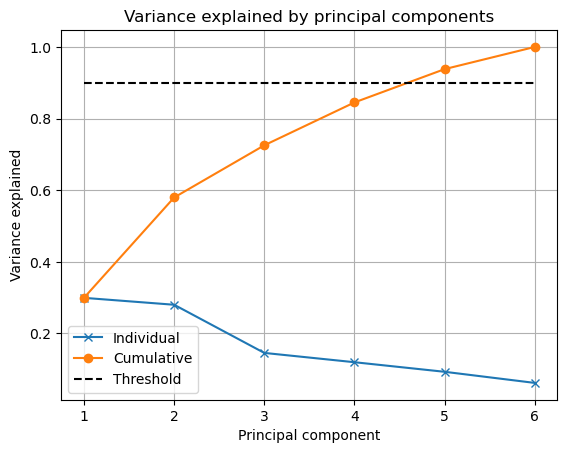

In [117]:
V = Vh.T

# Compute variance explained by principal components 
# Note: This is an important equation, see Eq. 3.18 on page 40 in the book.
rho = (S * S) / (S * S).sum()

threshold = 0.9

# Plot variance explained
plt.figure()
plt.plot(range(1, len(rho) + 1), rho, "x-")
plt.plot(range(1, len(rho) + 1), np.cumsum(rho), "o-")
plt.plot([1, len(rho)], [threshold, threshold], "k--")
plt.title("Variance explained by principal components")
plt.xlabel("Principal component")
plt.ylabel("Variance explained")
plt.legend(["Individual", "Cumulative", "Threshold"])
plt.grid()
plt.show()